In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [2]:
# Ensure this command is executed in an IPython environment (like a Jupyter notebook cell)
%load_ext autoreload
%autoreload 2

In [4]:
df_metered_monthly = pd.read_csv("df_metered_monthly_100 (1).csv")
df_unmetered_monthly = pd.read_csv("df_unmetered_monthly_100 (1).csv")

In [6]:
df_metered_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340297 entries, 0 to 3340296
Data columns (total 10 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   RND_ID                     int64  
 2   Consumption                float64
 3   hour                       int64  
 4   day_of_week                int64  
 5   month                      int64  
 6   is_weekend                 bool   
 7   Consumption_monthly_total  float64
 8   Consumption_monthly_avg    float64
 9   gmm_cluster                int64  
dtypes: bool(1), float64(3), int64(6)
memory usage: 232.5 MB


In [10]:

class EnergyDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.min_max_values = self.calculate_min_max_values(data)

    def calculate_min_max_values(self, data):
        min_max_values = {}
        for rnd_id, group in data.groupby('RND_ID'):
            min_max_values[rnd_id] = {}
            for hour in range(24):
                hour_group = group[group['hour'] == hour]
                min_max_values[rnd_id][hour] = {
                    'min_consumption': hour_group['Consumption'].min(),
                    'max_consumption': hour_group['Consumption'].max(),
                    'min_avg': hour_group['Consumption_monthly_avg'].min(),
                    'max_avg': hour_group['Consumption_monthly_avg'].max()
                }
        return min_max_values

    def normalize(self, value, min_value, max_value):
        return (value - min_value) / (max_value - min_value) if max_value > min_value else 0.5

    def denormalize(self, value, min_value, max_value):
        return value * (max_value - min_value) + min_value

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        rnd_id = row['RND_ID']
        hour = row['hour']
        min_max = self.min_max_values[rnd_id][hour]

        x = torch.tensor([self.normalize(row['Consumption'], min_max['min_consumption'], min_max['max_consumption'])], dtype=torch.float32)
        month_numeric = int(row['month'])
        day_of_week = row['day_of_week']
        is_weekend = int(row['is_weekend'])
        avg_normalized = self.normalize(row['Consumption_monthly_avg'], min_max['min_avg'], min_max['max_avg'])
        
        c = torch.tensor([month_numeric, day_of_week, is_weekend, avg_normalized], dtype=torch.float32)
        return {'x': x, 'c': c, 'rnd_id': rnd_id, 'hour': hour}

# Assuming you have loaded your data into df_metered_monthly and df_unmetered_monthly
# df_metered_monthly = pd.read_csv('path_to_metered.csv')
# df_unmetered_monthly = pd.read_csv('path_to_unmetered.csv')

# Create datasets
unmetered_dataset = EnergyDataset(df_unmetered_monthly)
metered_dataset = EnergyDataset(df_metered_monthly)

# Create dataloaders
train_loader = DataLoader(metered_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(unmetered_dataset, batch_size=32, shuffle=False)

# CVAE model
class CVAE(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim):
        super(CVAE, self).__init__()
        self.fc1 = nn.Linear(input_dim + condition_dim, 128)
        self.fc21 = nn.Linear(128, latent_dim)
        self.fc22 = nn.Linear(128, latent_dim)
        self.fc3 = nn.Linear(latent_dim + condition_dim, 128)
        self.fc4 = nn.Linear(128, input_dim)
        self.layer_norm1 = nn.LayerNorm(128)
        self.layer_norm2 = nn.LayerNorm(128)
        self.layer_norm3 = nn.LayerNorm(latent_dim)
        self.layer_norm4 = nn.LayerNorm(128)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                if m.bias is not None:
                    m.bias.data.fill_(0.01)

    def encode(self, x, c):
        h1 = torch.relu(self.fc1(torch.cat([x, c], dim=1)))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        logvar_clamped = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar_clamped)
        eps = torch.randn_like(std) * 1e-6
        z = mu + eps * std
        return z

    def decode(self, z, c):
        h3 = torch.relu(self.fc3(torch.cat([z, c], dim=1)))
        recon = torch.sigmoid(self.fc4(h3))
        return recon

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, c)
        return recon, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

input_dim = 1
condition_dim = 4
latent_dim = 20

model = CVAE(input_dim, condition_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        x, c = batch['x'], batch['c']
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x, c)
        loss = loss_function(recon_batch, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')



Epoch 1, Loss: 0.00041378023099163835
Epoch 2, Loss: 0.00011593979014688999
Epoch 3, Loss: 0.00010295827510364783
Epoch 4, Loss: 9.889584598912246e-05
Epoch 5, Loss: 6.921575044325328e-05


MSE: 190.65235891520885, MAE: 9.083315084286054


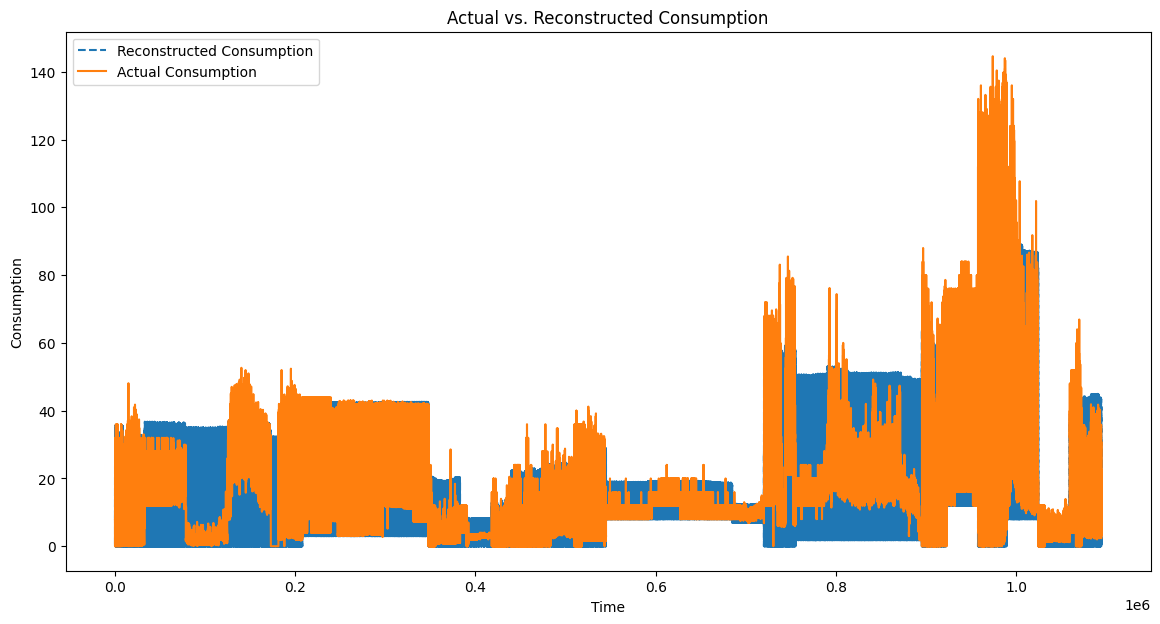

In [11]:
# Encode the training data to obtain latent space representations
latent_vectors = []
model.eval()
with torch.no_grad():
    for batch in train_loader:
        x, c = batch['x'], batch['c']
        mu, logvar = model.encode(x, c)
        z = model.reparameterize(mu, logvar)
        latent_vectors.append(z.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors)

# Fit a Gaussian Mixture Model to the latent space
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=0)
gmm.fit(latent_vectors)

# Use the GMM to sample the latent space during inference
reconstructed_data = []
with torch.no_grad():
    for batch in test_loader:
        c = batch['c']
        rnd_ids = batch['rnd_id']
        hours = batch['hour']
        
        # Sample z from the fitted GMM
        z = gmm.sample(n_samples=c.shape[0])[0]
        z = torch.tensor(z, dtype=torch.float32)
        
        recon_batch = model.decode(z, c)
        
        # Denormalize the reconstructed data
        for i, (rnd_id, hour) in enumerate(zip(rnd_ids, hours)):
            min_max = unmetered_dataset.min_max_values[rnd_id.item()][hour.item()]
            recon_batch[i] = unmetered_dataset.denormalize(recon_batch[i], min_max['min_consumption'], min_max['max_consumption'])
        
        reconstructed_data.append(recon_batch.cpu().numpy())

# Convert the list to a NumPy array
reconstructed_data = np.concatenate(reconstructed_data)

# Convert the reconstructed data to a DataFrame
df_reconstructed = pd.DataFrame(reconstructed_data, columns=['Reconstructed_Consumption'])

# Assuming df_unmetered_monthly is your test DataFrame
df_unmetered_monthly['Reconstructed_Consumption'] = df_reconstructed

if 'Consumption' in df_unmetered_monthly.columns:
    # Calculate the error metrics (e.g., MSE, MAE)
    mse = ((df_unmetered_monthly['Consumption'] - df_unmetered_monthly['Reconstructed_Consumption']) ** 2).mean()
    mae = (df_unmetered_monthly['Consumption'] - df_unmetered_monthly['Reconstructed_Consumption']).abs().mean()
    print(f'MSE: {mse}, MAE: {mae}')

    # Plot actual vs. reconstructed consumption
    plt.figure(figsize=(14, 7))
    plt.plot(df_unmetered_monthly['Reconstructed_Consumption'].values, label='Reconstructed Consumption', linestyle='--')
    plt.plot(df_unmetered_monthly['Consumption'].values, label='Actual Consumption')
    plt.xlabel('Time')
    plt.ylabel('Consumption')
    plt.title('Actual vs. Reconstructed Consumption')
    plt.legend()
    plt.show()
else:
    print("Actual consumption data is not available for comparison.")


In [13]:
# Encode the training data to obtain latent space representations
latent_vectors = []
model.eval()
with torch.no_grad():
    for batch in train_loader:
        x, c = batch['x'], batch['c']
        mu, logvar = model.encode(x, c)
        z = model.reparameterize(mu, logvar)
        latent_vectors.append(z.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors)

# Fit a Gaussian Mixture Model to the latent space
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=0)
gmm.fit(latent_vectors)

# Use the GMM to sample the latent space during inference
reconstructed_data = []
rnd_ids_list = []
hours_list = []

with torch.no_grad():
    for batch in test_loader:
        c = batch['c']  # Use the conditions for reconstruction
        rnd_ids = batch['rnd_id']
        hours = batch['hour']
        
        # Sample z from the fitted GMM
        z = gmm.sample(n_samples=c.shape[0])[0]
        z = torch.tensor(z, dtype=torch.float32)
        
        recon_batch = model.decode(z, c)
        
        # Collect the reconstructed data and corresponding rnd_ids and hours
        reconstructed_data.append(recon_batch.cpu().numpy())
        rnd_ids_list.append(rnd_ids.numpy())
        hours_list.append(hours.numpy())

# Convert the list to a NumPy array
reconstructed_data = np.concatenate(reconstructed_data)
rnd_ids_list = np.concatenate(rnd_ids_list)
hours_list = np.concatenate(hours_list)

# Convert the reconstructed data to a DataFrame
df_reconstructed = pd.DataFrame(reconstructed_data, columns=['Reconstructed_Consumption'])
df_reconstructed['RND_ID'] = rnd_ids_list
df_reconstructed['hour'] = hours_list

# Denormalize the reconstructed data
unmetered_dataset = EnergyDataset(df_unmetered_monthly)
df_reconstructed['Denormalized_Reconstructed_Consumption'] = df_reconstructed.apply(
    lambda row: unmetered_dataset.denormalize(
        row['Reconstructed_Consumption'],
        unmetered_dataset.min_max_values[row['RND_ID']][row['hour']]['min_consumption'],
        unmetered_dataset.min_max_values[row['RND_ID']][row['hour']]['max_consumption']
    ), axis=1
)

# Merge with the original test DataFrame for comparison
df_unmetered_monthly = df_unmetered_monthly.merge(df_reconstructed[['RND_ID', 'hour', 'Denormalized_Reconstructed_Consumption']], on=['RND_ID', 'hour'], how='left')

# Assuming df_unmetered_monthly has a 'Consumption' column for actual values
if 'Consumption' in df_unmetered_monthly.columns:
    # Calculate the error metrics (e.g., MSE, MAE)
    mse = ((df_unmetered_monthly['Consumption'] - df_unmetered_monthly['Denormalized_Reconstructed_Consumption']) ** 2).mean()
    mae = (df_unmetered_monthly['Consumption'] - df_unmetered_monthly['Denormalized_Reconstructed_Consumption']).abs().mean()
    print(f'MSE: {mse}, MAE: {mae}')

    # Plot actual vs. reconstructed consumption
    plt.figure(figsize=(14, 7))
    plt.plot(df_unmetered_monthly['Denormalized_Reconstructed_Consumption'].values, label='Reconstructed Consumption', linestyle='--')
    plt.plot(df_unmetered_monthly['Consumption'].values, label='Actual Consumption')
    plt.xlabel('Time')
    plt.ylabel('Consumption')
    plt.title('Actual vs. Reconstructed Consumption')
    plt.legend()
    plt.show()
else:
    print("Actual consumption data is not available for comparison.")


MemoryError: Unable to allocate 30.1 GiB for an array with shape (4033964386,) and data type int64

In [14]:
df_unmetered_monthly

,Unnamed: 0,RND_ID,Consumption,hour,day_of_week,month,is_weekend,Consumption_monthly_total,Consumption_monthly_avg,gmm_cluster,Reconstructed_Consumption
0,0,10038,8.00,0,6,1,True,32056.00,10.903401,0,8.294258
1,1,10038,8.00,0,6,1,True,32056.00,10.903401,0,8.640581
2,2,10038,8.00,0,6,1,True,32056.00,10.903401,0,7.644197
3,3,10038,8.00,0,6,1,True,32056.00,10.903401,0,6.782048
4,4,10038,8.00,1,6,1,True,32056.00,10.903401,0,6.013057
...,...,...,...,...,...,...,...,...,...,...,...
1094373,1094373,12893,4.64,22,6,12,True,58475.42,19.648999,3,5.883046
1094374,1094374,12893,4.70,23,6,12,True,58475.42,19.648999,3,4.175209
1094375,1094375,12893,4.50,23,6,12,True,58475.42,19.648999,3,4.101340
1094376,1094376,12893,4.79,23,6,12,True,58475.42,19.648999,3,6.911631
